# Noise removal autoencoder

In [1]:
from keras.datasets import mnist
from keras.layers import Input, Dense
from keras.models import Model
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.
c:\users\boltuzamaki\anaconda3\envs\pose\lib\site-packages\tensorflow\python\framework\dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\users\boltuzamaki\anaconda3\envs\pose\lib\site-packages\tensorflow\python\framework\dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\users\boltuzamaki\anaconda3\envs\pose\lib\site-packages\tensorflow\python\framework\dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
c:\users\boltuzamaki\anaconda3\e

In [2]:
#loading only images and not their labels
(X_train, _), (X_test, _) = mnist.load_data()

X_train = X_train.astype('float32')/255
X_test = X_test.astype('float32')/255

X_train = X_train.reshape(len(X_train), np.prod(X_train.shape[1:]))    # create X_train and X_test of shape(no_of_image, 784)
X_test = X_test.reshape(len(X_test), np.prod(X_test.shape[1:]))



X_train_noisy = X_train + np.random.normal(loc=0.0, scale=0.5, size=X_train.shape)   # add noise to the image value of image(0,1)
X_train_noisy = np.clip(X_train_noisy, 0., 1.)                 # So due to add noise it may go out of bond from 0-1 and when we
                                                               # clip 0-1 the some data lost as noise
X_test_noisy = X_test + np.random.normal(loc=0.0, scale=0.5, size=X_test.shape)
X_test_noisy = np.clip(X_test_noisy, 0., 1.)

print(X_train_noisy.shape)
print(X_test_noisy.shape)

(60000, 784)
(10000, 784)


In [3]:
#Input image

input_img= Input(shape=(784,))

# Creating layers

layer1 = Dense(units = 128, activation = 'relu')(input_img)        # encoder layers
layer2 = Dense(units = 64, activation = 'relu')(layer1)
layer3 =  Dense(units = 32, activation = 'relu')(layer2)        # We find Encodings here
layer4 = Dense(units = 64, activation = 'relu')(layer3)          # Decoder layers
layer5 = Dense(units = 128, activation = 'relu')(layer4)
final_layer =Dense(units = 784, activation = 'sigmoid')(layer5)   ## decoded image

# Building autoencoder
autoencoder=Model(input_img, final_layer)

In [4]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               100480    
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_4 (Dense)              (None, 64)                2112      
_________________________________________________________________
dense_5 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_6 (Dense)              (None, 784)               101136    
Total para

In [5]:
#extracting encoder

encoder = Model(input_img, layer3)

In [6]:
encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               100480    
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 32)                2080      
Total params: 110,816
Trainable params: 110,816
Non-trainable params: 0
_________________________________________________________________


In [7]:
# Creating decoder model

encoded_input = Input(shape=(32,))
decoder_layer3 = autoencoder.layers[-3](encoded_input)
decoder_layer2 = autoencoder.layers[-2](decoder_layer3)
decoder_layer1 = autoencoder.layers[-1](decoder_layer2) 

In [8]:
# Compiling decoder model

decoder = Model(encoded_input, decoder_layer1)
decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 32)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                2112      
_________________________________________________________________
dense_5 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_6 (Dense)              (None, 784)               101136    
Total params: 111,568
Trainable params: 111,568
Non-trainable params: 0
_________________________________________________________________


In [9]:
# compiling the autoencoder

autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy', metrics=['accuracy'])

In [10]:
# Fitting the noise trained data to the autoencoder 

autoencoder.fit(X_train_noisy, X_train,
                epochs=100,
                batch_size=256,
                shuffle=True,
                validation_data=(X_test_noisy, X_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 5s 90us/step - loss: 0.3113 - acc: 0.7691 - val_loss: 0.2621 - val_acc: 0.7908
Epoch 2/100
60000/60000 [==============================] - 2s 32us/step - loss: 0.2583 - acc: 0.7986 - val_loss: 0.2553 - val_acc: 0.7920
Epoch 3/100
60000/60000 [==============================] - 2s 34us/step - loss: 0.2486 - acc: 0.7951 - val_loss: 0.2426 - val_acc: 0.7941
Epoch 4/100
60000/60000 [==============================] - 2s 31us/step - loss: 0.2377 - acc: 0.7938 - val_loss: 0.2311 - val_acc: 0.7927
Epoch 5/100
60000/60000 [==============================] - 2s 31us/step - loss: 0.2297 - acc: 0.7934 - val_loss: 0.2272 - val_acc: 0.7951
Epoch 6/100
60000/60000 [==============================] - 2s 33us/step - loss: 0.2229 - acc: 0.7943 - val_loss: 0.2170 - val_acc: 0.7972
Epoch 7/100
60000/60000 [==============================] - 2s 33us/step - loss: 0.2123 - acc: 0.7954 - val_loss: 0.2055 - 

60000/60000 [==============================] - 2s 30us/step - loss: 0.1336 - acc: 0.8086 - val_loss: 0.1338 - val_acc: 0.8088
Epoch 60/100
60000/60000 [==============================] - 2s 30us/step - loss: 0.1332 - acc: 0.8087 - val_loss: 0.1324 - val_acc: 0.8083
Epoch 61/100
60000/60000 [==============================] - 2s 30us/step - loss: 0.1329 - acc: 0.8087 - val_loss: 0.1336 - val_acc: 0.8093
Epoch 62/100
60000/60000 [==============================] - 2s 30us/step - loss: 0.1325 - acc: 0.8088 - val_loss: 0.1316 - val_acc: 0.8087
Epoch 63/100
60000/60000 [==============================] - 2s 31us/step - loss: 0.1323 - acc: 0.8088 - val_loss: 0.1333 - val_acc: 0.8093
Epoch 64/100
60000/60000 [==============================] - 2s 31us/step - loss: 0.1320 - acc: 0.8089 - val_loss: 0.1318 - val_acc: 0.8071
Epoch 65/100
60000/60000 [==============================] - 2s 31us/step - loss: 0.1317 - acc: 0.8089 - val_loss: 0.1315 - val_acc: 0.8067
Epoch 66/100
60000/60000 [==============

In [11]:
# reconstructing the image from autoencoder and encoder

encoded_imgs = encoder.predict(X_test_noisy)      # Creating a encoded value using image
predicted = autoencoder.predict(X_test_noisy)     # Using a noisy image to create its clean version
decoder_predict = decoder.predict(encoded_imgs)   # Decoded image of encoded value

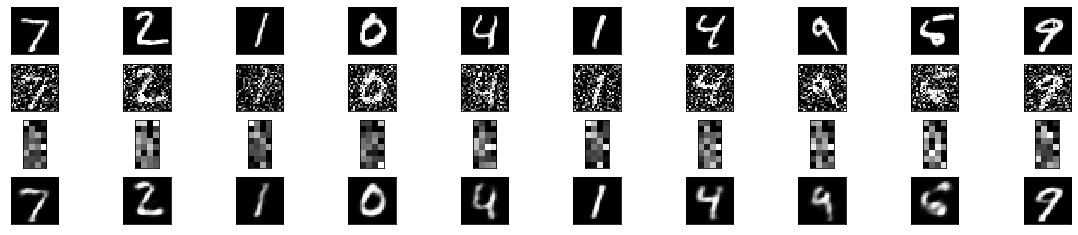

In [12]:
# plotting the noised image, encoded image and the reconstructed image
plt.figure(figsize=(40, 4))
for i in range(10):
# display original images
    
    ax = plt.subplot(4, 20, i + 1)
    plt.imshow(X_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
# display noised images
    ax = plt.subplot(4, 20, i + 1+20)
    plt.imshow(X_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
# display encoded images    
    ax = plt.subplot(4, 20, 2*20+i + 1 )
    plt.imshow(encoded_imgs[i].reshape(8,4))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
# display reconstruction images
    ax = plt.subplot(4, 20, 3*20 +i+ 1)
    plt.imshow(decoder_predict[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    
plt.show()

In [13]:
# Saving model and weights of autoencoder
model_json = autoencoder.to_json()
with open("noise_removal_autoencoder_model", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
autoencoder.save_weights("noise_removal_autoencoder_model.h5"),
print("Saved model to disk")

Saved model to disk


In [14]:
# Saving model and weights of encoder
model_json = encoder.to_json()
with open("noise_removal_model_encoder_only", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
encoder.save_weights("noise_removal_autoencoder_model_encoder_only.h5"),
print("Saved model to disk")

Saved model to disk


In [15]:
# Saving model and weights of decoder
model_json = decoder.to_json()
with open("noise_removal_autoencoder_model_decoder_only", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
decoder.save_weights("noise_removal_autoencoder_model_decoder_only.h5"),
print("Saved model to disk")

Saved model to disk
